In [ ]:
# !pip install transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=39ea94b3e0a254a0404d7f767b0e01a7bfc8fde453cdbb44a4944a613792a841
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
from datasets import Dataset, DatasetDict
import pandas as pd

def read_conll(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    tokens, labels = [], []
    current_tokens, current_labels = [], []

    for line in lines:
        line = line.strip()
        if line:
            token, label = line.split()  # Assuming space-separated
            current_tokens.append(token)
            current_labels.append(label)
        else:
            if current_tokens:
                tokens.append(current_tokens)
                labels.append(current_labels)
                current_tokens, current_labels = [], []

    # Add the last sentence if file doesn't end with newline
    if current_tokens:
        tokens.append(current_tokens)
        labels.append(current_labels)

    return {"tokens": tokens, "ner_tags": labels}

# Load data
data = read_conll("data.txt")
df = pd.DataFrame(data)

# Split 80/20
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

# Convert to Dataset
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")

# Map labels to IDs
label_list = sorted(list(set(tag for tags in data["ner_tags"] for tag in tags)))
label2id = {tag: i for i, tag in enumerate(label_list)}

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )

    labels = []
    for i, tags in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[tags[word_idx]])
            else:
                label_ids.append(-100)  # For subword tokens
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/2533 [00:00<?, ? examples/s]

Map:   0%|          | 0/633 [00:00<?, ? examples/s]

In [4]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
from seqeval.metrics import classification_report, accuracy_score

# Define label mappings (must run after loading data)
label_list = sorted(list(set(tag for tags in data["ner_tags"] for tag in tags)))
label2id = {tag: i for i, tag in enumerate(label_list)}
id2label = {i: tag for tag, i in label2id.items()}

# Initialize model
model = AutoModelForTokenClassification.from_pretrained(
    "FacebookAI/xlm-roberta-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./ner_results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
)

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for l in label if l != -100]
        for label in labels
    ]

    # Calculate metrics
    results = classification_report(true_labels, true_predictions, output_dict=True)
    accuracy = accuracy_score(true_labels, true_predictions)

    return {
        "precision": results["macro avg"]["precision"],
        "recall": results["macro avg"]["recall"],
        "f1": results["macro avg"]["f1-score"],
        "accuracy": accuracy,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: addisum443 (addisum443-addis-ababa-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.041099,0.945904,0.933714,0.939705,0.989962
2,No log,0.024915,0.965265,0.964473,0.964830,0.995064
3,No log,0.027680,0.969851,0.970036,0.969924,0.995064
4,0.071100,0.021770,0.970883,0.974502,0.972650,0.995627
5,0.071100,0.021084,0.977492,0.980436,0.978946,0.996389


TrainOutput(global_step=795, training_loss=0.04687224679023215, metrics={'train_runtime': 847.4745, 'train_samples_per_second': 14.944, 'train_steps_per_second': 0.938, 'total_flos': 827353295558400.0, 'train_loss': 0.04687224679023215, 'epoch': 5.0})

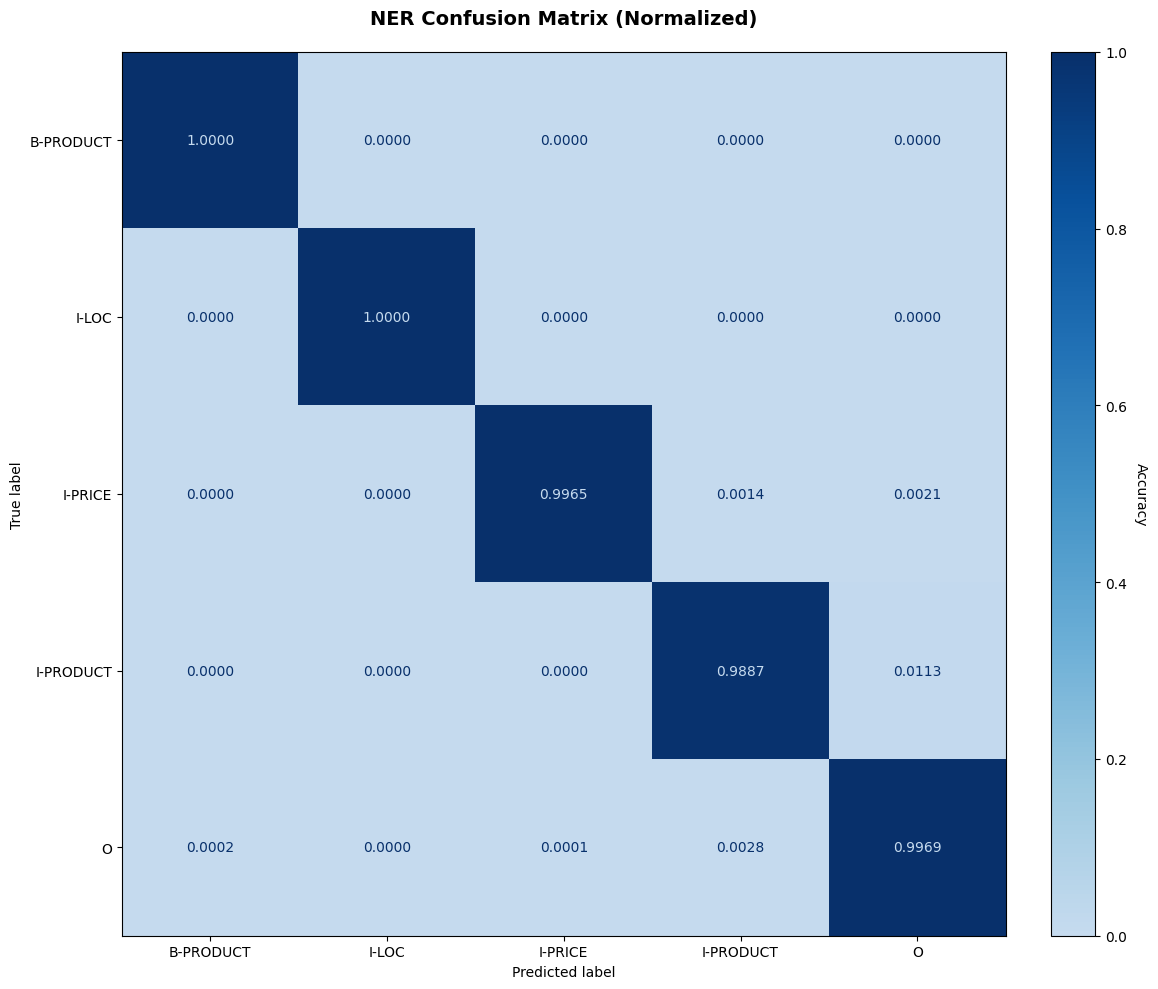

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

# Get predictions
predictions = trainer.predict(tokenized_datasets["validation"])
preds = np.argmax(predictions.predictions, axis=2)

# Flatten labels and preds (ignore -100)
true_labels = [label for batch in predictions.label_ids for label in batch if label != -100]
flat_preds = [pred for batch, labels in zip(preds, predictions.label_ids)
              for pred, label in zip(batch, labels) if label != -100]

# Create confusion matrix
cm = confusion_matrix(true_labels, flat_preds, normalize="true")

# Create blue-white colormap
blue_colors = plt.cm.Blues(np.linspace(0, 1, 256))
white_blue_colors = blue_colors[64:]  # Skip the very light blues
cmap = matplotlib.colors.ListedColormap(white_blue_colors)

# Plot with custom styling
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_list
)
disp.plot(
    cmap=cmap,
    ax=ax,
    values_format=".4f",
    colorbar=False,
)

# Add title and adjust layout
plt.title("NER Confusion Matrix (Normalized)", pad=20, fontsize=14, weight='bold')
plt.tight_layout()

# Add colorbar
cbar = plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Accuracy', rotation=270, labelpad=15)

plt.show()

In [6]:
model.save_pretrained("./amharic_ner_model")
tokenizer.save_pretrained("./amharic_ner_model")

('./amharic_ner_model/tokenizer_config.json',
 './amharic_ner_model/special_tokens_map.json',
 './amharic_ner_model/sentencepiece.bpe.model',
 './amharic_ner_model/added_tokens.json',
 './amharic_ner_model/tokenizer.json')

In [7]:
from transformers import pipeline

# 1. Load your saved model
ner_model = pipeline(
    task="ner",
    model="./amharic_ner_model",  # Path to your saved model
    tokenizer="./amharic_ner_model",  # Path to your saved tokenizer
    aggregation_strategy="simple",  # Groups subwords into whole words
    device=0  # Use GPU (set to -1 for CPU)
)

# 2. Test text (replace with your Amharic text)
test_text = "3pcs silicon brush ዋጋ-550ብር መገናኛ #ዛም_ሞል"

# 3. Get predictions
results = ner_model(test_text)

# 4. Print formatted results
print(f"\nInput Text: '{test_text}'\n")
print("Detected Entities:")
for entity in results:
    print(f"""
    Entity: {entity['word']}
    Type: {entity['entity_group']}
    Confidence: {entity['score']:.2%}
    Position: Characters {entity['start']}-{entity['end']}
    """)

# 5. Extract specific entity types
print("\nSummary:")
print(f"Products: {[e['word'] for e in results if e['entity_group'] == 'PRODUCT']}")
print(f"Prices: {[e['word'] for e in results if e['entity_group'] == 'PRICE']}")
print(f"Locations: {[e['word'] for e in results if e['entity_group'] == 'LOCATION']}")

Device set to use cuda:0



Input Text: '3pcs silicon brush ዋጋ-550ብር መገናኛ #ዛም_ሞል'

Detected Entities:

    Entity: 3pcs silicon brush
    Type: PRODUCT
    Confidence: 99.94%
    Position: Characters 0-18
    

    Entity: ዋጋ-550ብር
    Type: PRICE
    Confidence: 99.59%
    Position: Characters 19-27
    

    Entity: መ
    Type: LOC
    Confidence: 99.85%
    Position: Characters 28-29
    

Summary:
Products: ['3pcs silicon brush']
Prices: ['ዋጋ-550ብር']
Locations: []


In [12]:
!pip install lime  # Install LIME if you haven't already

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cfb56fca596eb6a2d1fb03405c8e85769dee087c7375a68907755425fba0019d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Device set to use cuda:0


Model's label mapping: {0: 'B-PRODUCT', 1: 'I-LOC', 2: 'I-PRICE', 3: 'I-PRODUCT', 4: 'O'}
Available classes: ['B-PRODUCT', 'I-LOC', 'I-PRICE', 'I-PRODUCT', 'O']

=== Model Predictions ===
  3pcs silicon brush → PRODUCT (1.00)
            ዋጋ-550ብር → PRICE (1.00)
                   መ → LOC (1.00)

Explaining: B-PRODUCT

=== LIME Explanation ===
Error: Class 'B-PRODUCT' not found in label2id
Available classes: ['B-PRODUCT', 'I-LOC', 'I-PRICE', 'I-PRODUCT', 'O']


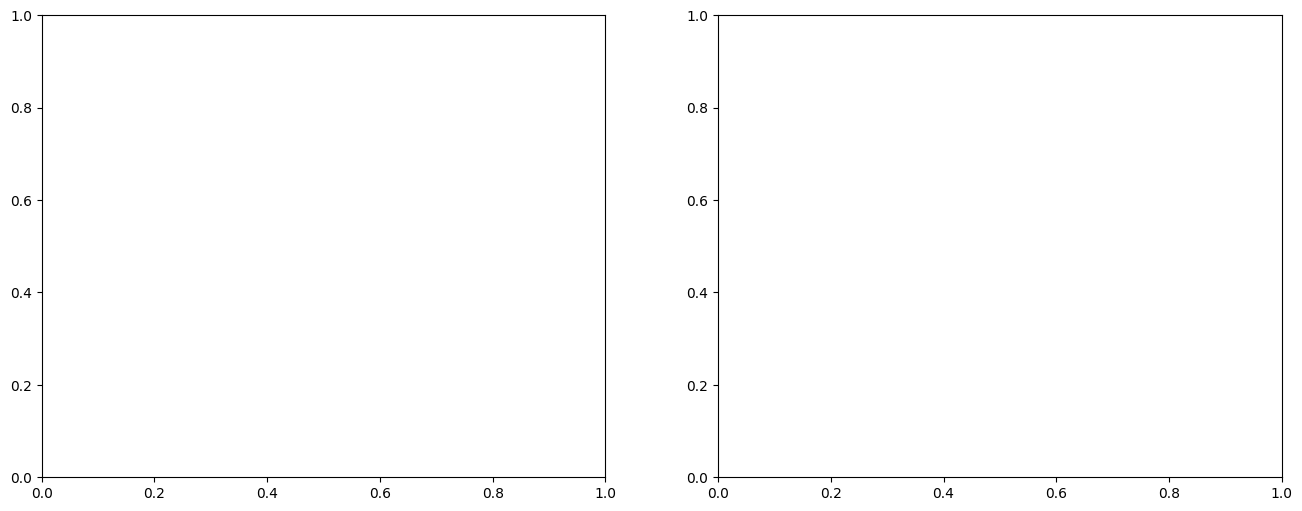

In [21]:
import numpy as np
from lime.lime_text import LimeTextExplainer
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
import torch
import matplotlib.pyplot as plt

# 1. Initialize NER Pipeline
model_path = "./amharic_ner_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

# Check the model's actual label mapping
print("Model's label mapping:", model.config.id2label)

# 2. Define Label Mappings based on model's actual outputs
class_names = list(model.config.id2label.values())  # Use model's own labels
label2id = {tag: i for i, tag in enumerate(class_names)}
id2label = {i: tag for tag, i in label2id.items()}

print("Available classes:", class_names)

# 3. Initialize NER Pipeline with correct label mapping
ner_model = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple",
    device=0 if torch.cuda.is_available() else -1
)

# 4. Custom Tokenizer Aligned with Model
def custom_tokenizer(text):
    encoded = tokenizer(text, return_offsets_mapping=True)
    tokens = []
    for token_id, offset in zip(encoded.input_ids, encoded.offset_mapping):
        if token_id in [tokenizer.cls_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id]:
            continue
        start, end = offset
        tokens.append(text[start:end])
    return tokens

# 5. Enhanced Prediction Function
def ner_predict_proba(texts):
    batch_results = []
    for text in texts:
        entities = ner_model(text)
        output = np.ones(len(class_names)) * 1e-10  # Small epsilon

        for entity in entities:
            entity_type = entity['entity_group']
            if entity_type in label2id:
                output[label2id[entity_type]] += entity['score']

        # Softmax normalization
        output = np.exp(output) / np.sum(np.exp(output))
        batch_results.append(output.reshape(1, -1))

    return np.vstack(batch_results)

# 6. Create Explainer
explainer = LimeTextExplainer(
    class_names=class_names,
    split_expression=custom_tokenizer,
    bow=False,
    random_state=42
)

# 7. Example Analysis
test_text = "3pcs silicon brush ዋጋ-550ብር መገናኛ #ዛም_ሞል"

# First verify predictions
print("\n=== Model Predictions ===")
predictions = ner_model(test_text)
for ent in predictions:
    print(f"{ent['word']:>20} → {ent['entity_group']} ({ent['score']:.2f})")

if predictions:
    target_class = "B-PRODUCT"
    print(f"\nExplaining: {target_class}")

    try:
        # Run LIME explanation
        exp = explainer.explain_instance(
            test_text,
            ner_predict_proba,
            num_features=10,
            top_labels=3,
            labels=[label2id[target_class]],
            num_samples=2000
        )

        # Visualization
        print("\n=== LIME Explanation ===")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Text plot
        exp.as_pyplot_figure(label=label2id[target_class])
        plt.title(f"LIME Weights for {target_class}", pad=20)

        # Bar plot
        features = exp.as_list(label=label2id[target_class])
        features.sort(key=lambda x: abs(x[1]), reverse=True)
        words, weights = zip(*features)
        colors = ['green' if w > 0 else 'red' for w in weights]

        ax2.barh(words, weights, color=colors)
        ax2.set_title(f"Feature Importance for {target_class}")
        ax2.set_xlabel("Contribution Weight")
        ax2.axvline(0, color='black', linestyle='--')

        plt.tight_layout()
        plt.show()

        # Raw output
        print("\nDetailed Weights:")
        for word, weight in features:
            print(f"{word:>30}: {weight:+.4f}")

    except KeyError:
        print(f"Error: Class '{target_class}' not found in label2id")
        print("Available classes:", class_names)
else:
    print("No entities detected in text")

In [ ]:
!cp "final.zip" "/content/drive/MyDrive/"